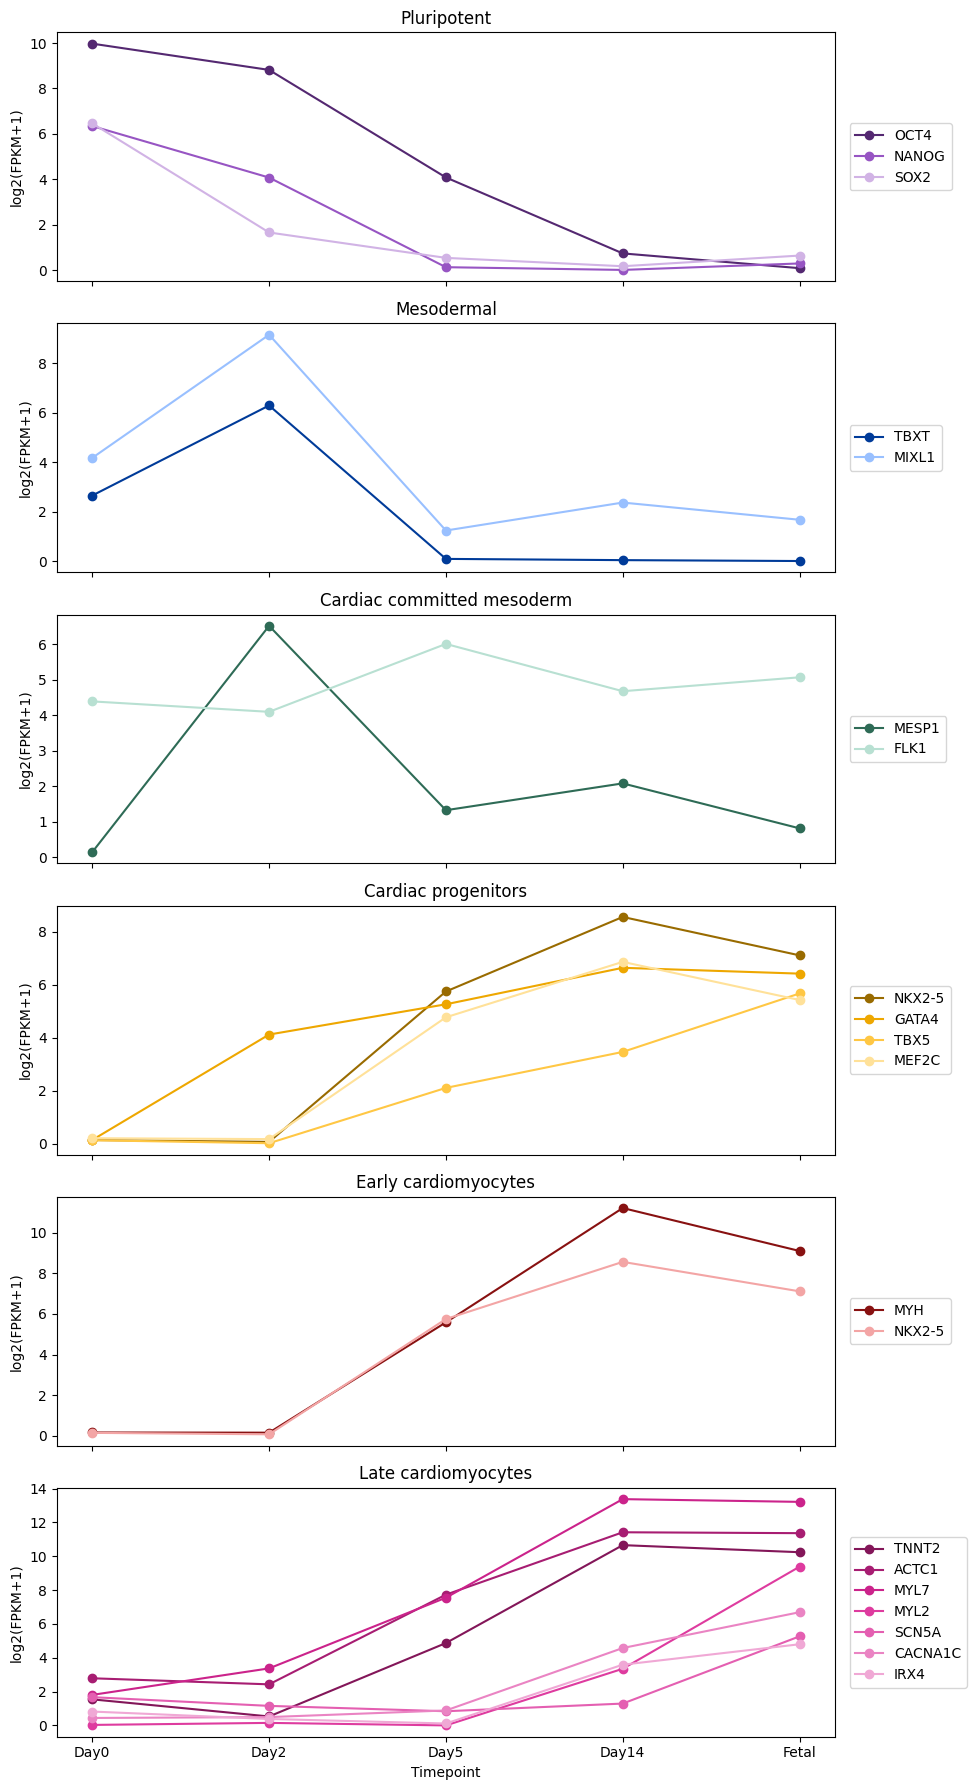

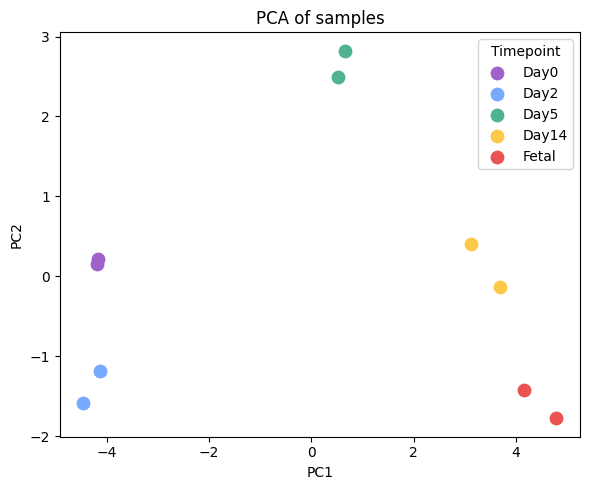

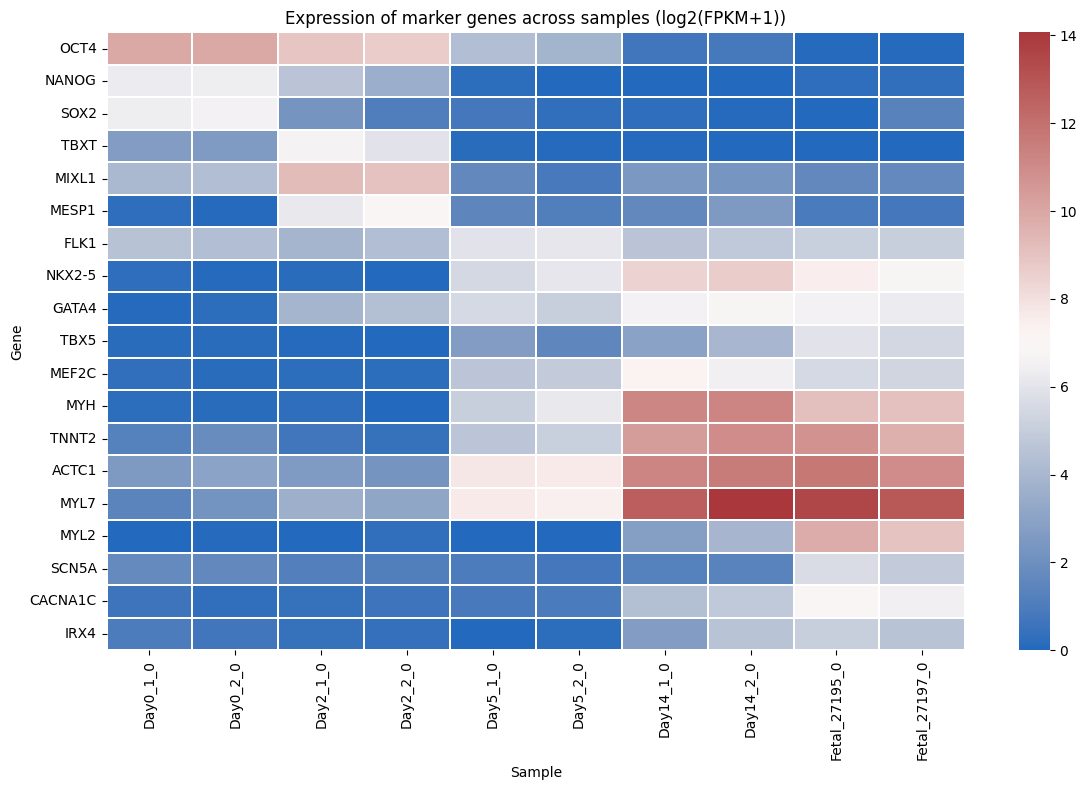

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib.colors import to_rgb, to_hex
import colorsys

# Load FPKM table
df = pd.read_csv("GSE106688_genes.fpkm_table.txt", sep="\t")

# Define gene-to-ID mapping
gene_map = {
    "OCT4": "ENSG00000204531", "NANOG": "ENSG00000111704", "SOX2": "ENSG00000181449",
    "TBXT": "ENSG00000164458", "MIXL1": "ENSG00000185155", "MESP1": "ENSG00000166823", "FLK1": "ENSG00000128052",
    "NKX2-5": "ENSG00000183072", "GATA4": "ENSG00000136574", "TBX5": "ENSG00000089225", "MEF2C": "ENSG00000081189",
    "MYH": "ENSG00000197616", "TNNT2": "ENSG00000118194", "ACTC1": "ENSG00000159251",
    "MYL7": "ENSG00000106631", "MYL2": "ENSG00000111245", "SCN5A": "ENSG00000183873",
    "CACNA1C": "ENSG00000151067", "IRX4": "ENSG00000113430"
}

# Define sample groups
group_map = {
    "Day0": ["Day0_1_0", "Day0_2_0"],
    "Day2": ["Day2_1_0", "Day2_2_0"],
    "Day5": ["Day5_1_0", "Day5_2_0"],
    "Day14": ["Day14_1_0", "Day14_2_0"],
    "Fetal": ["Fetal_27195_0", "Fetal_27197_0"]
}

# Define differentiation stages and color palette
stages = {
    "Pluripotent": ["OCT4", "NANOG", "SOX2"],
    "Mesodermal": ["TBXT", "MIXL1"],
    "Cardiac committed mesoderm": ["MESP1", "FLK1"],
    "Cardiac progenitors": ["NKX2-5", "GATA4", "TBX5", "MEF2C"],
    "Early cardiomyocytes": ["MYH", "NKX2-5"],
    "Late cardiomyocytes": ["TNNT2", "ACTC1", "MYL7", "MYL2", "SCN5A", "CACNA1C", "IRX4"]
}

stage_colors = ["#9f62c8", "#75aaff", "#4fb390", "#ffc94a", "#e95353", "#dd389e"]
stage_color_map = dict(zip(stages.keys(), stage_colors))

# Log-transform FPKM values
df_markers = df.set_index("tracking_id").loc[gene_map.values()]
df_markers.index = gene_map.keys()
log_fpkm = np.log2(df_markers + 1)

# Pool samples per timepoint
pooled_expr = pd.DataFrame({tp: log_fpkm[samples].mean(axis=1) for tp, samples in group_map.items()})

# Generate shades of a color for plotting
def hls_shades(hex_color, n, l_min=0.3, l_max=0.8):
    h, l, s = colorsys.rgb_to_hls(*to_rgb(hex_color))
    return [to_hex(colorsys.hls_to_rgb(h, l_, s)) for l_ in np.linspace(l_min, l_max, n)]

# Plot gene expression per stage
fig, axes = plt.subplots(len(stages), 1, figsize=(10, 3 * len(stages)), sharex=True)
for ax, (stage, genes) in zip(axes, stages.items()):
    genes = [g for g in genes if g in pooled_expr.index]
    shades = hls_shades(stage_color_map[stage], len(genes))
    for g, c in zip(genes, shades):
        ax.plot(pooled_expr.columns, pooled_expr.loc[g], label=g, color=c, marker="o")
    ax.set_title(stage)
    ax.set_ylabel("log2(FPKM+1)")
    ax.legend(loc='center left', bbox_to_anchor=(1.01, 0.5))
axes[-1].set_xlabel("Timepoint")
plt.tight_layout()
plt.show()

# PCA on all samples
ordered_groups = list(group_map.keys())
group_colors = dict(zip(ordered_groups, stage_colors[:len(ordered_groups)]))
pca_df = pd.DataFrame(
    PCA(n_components=2).fit_transform(StandardScaler().fit_transform(log_fpkm.T)),
    columns=["PC1", "PC2"], index=log_fpkm.columns
)
pca_df["group"] = pca_df.index.map(lambda x: next((g for g, s in group_map.items() if x in s), None))
pca_df["color"] = pca_df["group"].map(group_colors)

plt.figure(figsize=(6, 5))
for grp in ordered_groups:
    sub = pca_df[pca_df["group"] == grp]
    plt.scatter(sub["PC1"], sub["PC2"], label=grp, color=group_colors[grp], s=80)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of samples")
plt.legend(title="Timepoint")
plt.tight_layout()
plt.show()

# Heatmap of all marker genes across samples
plt.figure(figsize=(12, 8))
sns.heatmap(log_fpkm.loc[df_markers.index], cmap="vlag", linewidths=0.3, xticklabels=True, yticklabels=True)
plt.title("Expression of marker genes across samples (log2(FPKM+1))")
plt.xlabel("Sample")
plt.ylabel("Gene")
plt.tight_layout()
plt.show()
